In [1]:
import torch, json
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

BATCH_SIZE = 60000  

transform = transforms.Compose([
    transforms.ToTensor(),         
    transforms.Normalize((0.1307,), (0.3081,)) 
])

train_dataset = datasets.MNIST('../data', train=True, download=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = datasets.MNIST('../data', train=False, download=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = x.view(-1, 28 * 28) 
        outputs = self.linear(x)
        return outputs

def train(model, optimizer, criterion, opt_type, n_epochs=5, eval=False):
    model.train()
    train_losses = {}
    test_losses = {}
    for epoch in range(n_epochs):
        train_losses[epoch] = 0.0
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_losses[epoch] += loss.item()

            if eval:
                model.eval()
                test_losses[epoch] = 0.0
                correct = 0
                with torch.no_grad():
                    for data, target in test_loader:
                        output = model(data)
                        test_losses[epoch] += criterion(output, target).item()
                        pred = output.argmax(dim=1, keepdim=True)
                        correct += pred.eq(target.view_as(pred)).sum().item()
                test_losses[epoch] /= len(test_loader.dataset)

    with open(f'./metrics/train_{opt_type}_loss.json', 'w') as f:
        json.dump(train_losses, f)
    with open(f'./metrics/test_{opt_type}_loss.json', 'w') as f:
        json.dump(test_losses, f)

In [2]:
NUM_EPOCHS = 5
LEARNING_RATE = 0.01
input_dim = 28 * 28
output_dim = 10

def model_training(opt_type):
    model = LogisticRegression(input_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    if opt_type == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
    elif opt_type == 'ada':
        optimizer = optim.Adagrad(model.parameters(), lr=LEARNING_RATE)
    elif opt_type == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    train(model, optimizer, criterion, opt_type=opt_type, n_epochs=NUM_EPOCHS, eval=True)

model_training('sgd')
model_training('ada')
model_training('adam')

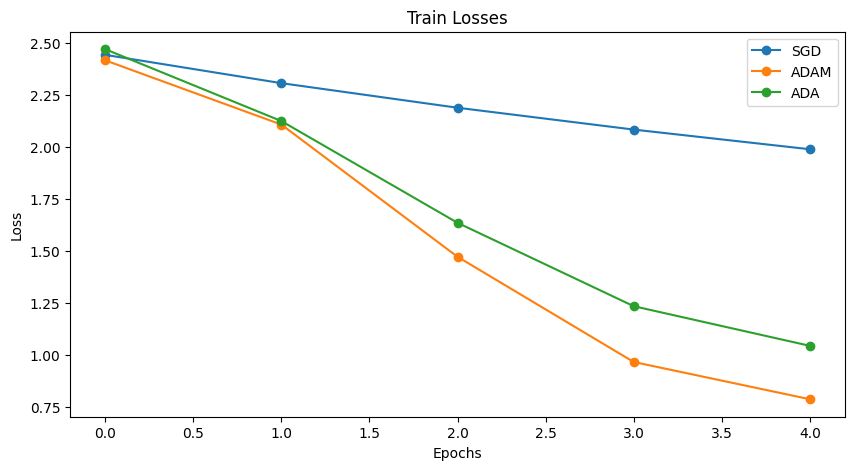

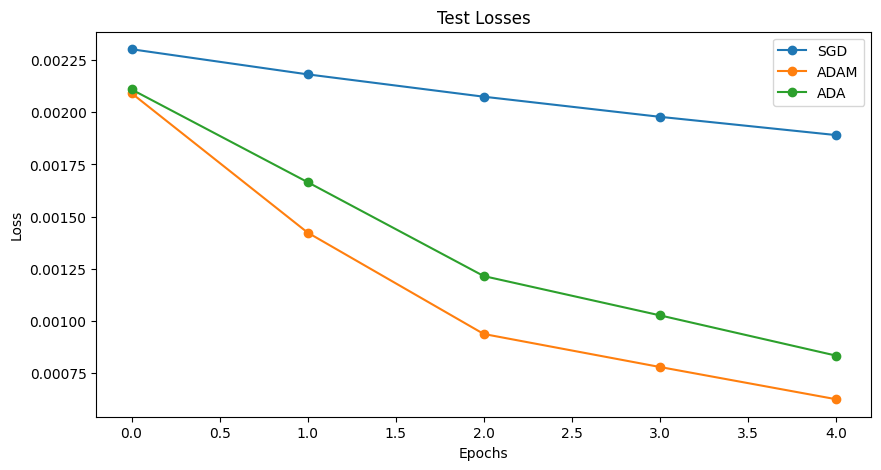

In [3]:
train_losses_dict = {}
test_losses_dict = {}

for opt in ['sgd', 'adam', 'ada']:
    with open(f'./metrics/train_{opt}_loss.json', 'r') as f:
        train_losses_dict[opt] = json.load(f)
    with open(f'./metrics/test_{opt}_loss.json', 'r') as f:
        test_losses_dict[opt] = json.load(f)

def plot_losses(losses_dict, title, xlabel, ylabel):
    plt.figure(figsize=(10, 5))
    for opt, losses in losses_dict.items():
        epochs = list(map(int, losses.keys()))
        loss_values = list(losses.values())
        plt.plot(epochs, loss_values, marker='o', label=f'{opt.upper()}')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

plot_losses(train_losses_dict, 'Train Losses', 'Epochs', 'Loss')
plot_losses(test_losses_dict, 'Test Losses', 'Epochs', 'Loss')
